In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from preprocess import preprocess

In [2]:
data = pickle.load(open('../Data/unimputed_inr_patient_data.pkl', 'rb'), encoding='latin1')

In [3]:
data[0]

{'nsaid_times': [],
 'transfusion_times': [array([], dtype=float64), array([], dtype=float64)],
 'obs_times': array([120.]),
 'event_time': 650.0,
 'sepsis': 0,
 'chronic_names': ['liver_disease', 'sickle_cell'],
 'demographic': array([32.]),
 'anticoagulant_times': [],
 'marker_name': 'inr',
 'aspirin_times': [],
 'chronic': array([0., 0.]),
 'transfusion_names': ['transfuse_plasma', 'transfuse_platelets'],
 'obs_y': array([0.9]),
 'nsaid_names': ['acetaminophen_dose',
  'celecoxib_dose',
  'diclofenac_dose',
  'ibuprofen_dose',
  'indomethacin_dose',
  'ketorolac_dose',
  'meloxicam_dose',
  'naproxen_dose'],
 'excess_alcohol': 0.0,
 'inr_orgdf': 0,
 'anticoagulant_names': ['warfarin_dose',
  'heparin_dose',
  'dabigatran_dose',
  'edoxaban_dose',
  'rivaroxaban_dose',
  'apixaban_dose',
  'enoxaparin_dose',
  'dalteparin_dose',
  'fondaparinux_dose'],
 'id': 8,
 'demographic_names': ['age']}

### Information for building pipeline

In [4]:
len(data)

31535

In [5]:
ids = []
for d in data:
    ids.append(d['id'])

### Some notes on the data
* 4 types of treatments: nsaid (8), transfusion (2), anticoagulant (9), aspirin (1)
* 2 types of chronic conditions: liver disease, sickle cell
* 1 demographic information: age (integer)
* 2 other informations: excess alcohol (binary), sepsis (binary)  

### Things to determine
* Cutoff point for number of observations
* How to determine the time interval? Since we can deal with missing value relatively well, we want to make the interval as fine grain as possible to maximize data usage. Average interval between observations and treatments are all around 1000. 95% of intervals for obs and aspirin are larger than 900-1000; 95% of intervals of anticoagulant and nsaid are larger than 400-500. 
* After specifying the interval, what if there are multiple values in that interval? Take average?
* A small number of patients have received treatments befort the first observation. Should we consider the first observation as the starting point for each time series and simply disrecard those treatments and let the initial state value capture their effects?

Patients with obs times >= 5: 2524.0
Patients with obs times >= 10: 651.0
Patients with obs times >= 15: 212.0
Patients with obs times >= 20: 95.0


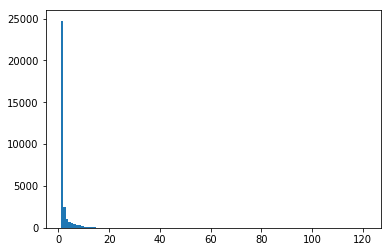

In [6]:
data_5 = []
data_7 = []
data_10 = []
num_obs = []
for d in data:
    num = d['obs_times'].shape[0]
    num_obs.append(num)
    if num >= 5:
        data_5.append(d)
    if num >= 7:
        data_7.append(d)
    if num >= 10:
        data_10.append(d)

max_num_obs = max(num_obs)
num_obs_hist = plt.hist(num_obs, bins = max_num_obs, range=(1, max_num_obs))[0]

print('Patients with obs times >= 5: {}'.format(np.sum(num_obs_hist[4:])))
print('Patients with obs times >= 10: {}'.format(np.sum(num_obs_hist[9:])))
print('Patients with obs times >= 15: {}'.format(np.sum(num_obs_hist[14:])))
print('Patients with obs times >= 20: {}'.format(np.sum(num_obs_hist[19:])))

In [7]:
data = data_5

### Observational time

In [8]:
def time_span(data, name):
    time_span = []
    for d in data:
        time_span.append(d['obs_times'][-1] - d['obs_times'][0])
    return time_span 
        
def avg_interval(data, name):
    avg_interval = []
    for d in data:
        if type(d[name+'_times']) is list and len(d[name+'_times']) < 2:
            continue
        diff = np.subtract(d[name+'_times'], np.roll(d[name+'_times'], shift=1))
        diff = np.delete(diff, 0)
        avg_interval.append(np.average(diff))
    return avg_interval
    
def avg_times_of(data, name):
    num = []
    for d in data:
        num.append(d[name + '_times'].shape[0])
    print('avg number of ' + name + ': {}'.format(np.average(num)))

In [9]:
print('avg overall time span of obs: {}'.format(np.mean(time_span(data, 'obs'))))
print('avg interval between obs: {}'.format(np.mean(avg_interval(data, 'obs'))))
avg_times_of(data, 'obs')

avg overall time span of obs: 11501.120839936608
avg interval between obs: 1496.3954056598004
avg number of obs: 8.707606973058637


In [10]:
print('95% has avg interval between obs larger than: {}'.format(np.percentile(avg_interval(data, 'obs'), 5)))

95% has avg interval between obs larger than: 909.5339285714285


### INR values

(array([6400., 5685., 4069., 2781., 1157.,  766.,  417.,  205.,  143.,
          81.,   72.,   34.,   31.,   43.,   23.,   29.,   10.,   13.,
           9.,   10.]),
 array([ 0.8 ,  1.36,  1.92,  2.48,  3.04,  3.6 ,  4.16,  4.72,  5.28,
         5.84,  6.4 ,  6.96,  7.52,  8.08,  8.64,  9.2 ,  9.76, 10.32,
        10.88, 11.44, 12.  ]),
 <a list of 20 Patch objects>)

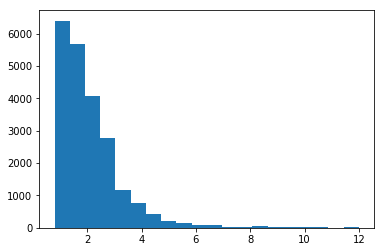

In [11]:
inr = []
for d in data:
    inr.append(d['obs_y'])
inr_arr = np.concatenate(inr)
inr_hist = plt.hist(inr_arr, bins = 20)
inr_hist

### Age

(array([ 22.,  63.,  72., 118., 228., 286., 436., 521., 563., 215.]),
 array([17. , 25.1, 33.2, 41.3, 49.4, 57.5, 65.6, 73.7, 81.8, 89.9, 98. ]),
 <a list of 10 Patch objects>)

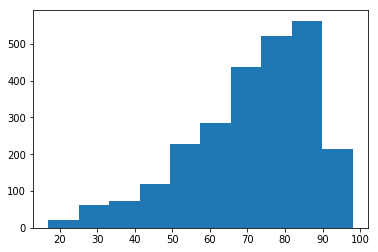

In [12]:
age = []
for d in data:
    age.append(d['demographic'])
age_arr = np.concatenate(age)
age_hist = plt.hist(age_arr, bins = 10)
age_hist

### Chronic

In [13]:
liver = np.zeros(len(data))
sickle = np.zeros(len(data))
for i, d in enumerate(data):
    liver[i] = d['chronic'][0]
    sickle[i] = d['chronic'][1]
liver_num = np.unique(liver, return_counts=True)[1]
sickle_num = np.unique(sickle, return_counts=True)[1]
print('No liver disease: {}; with liver disease: {}'.format(liver_num[0], liver_num[1]))
print('No sickle cell: {}; with sickle cell: {}'.format(sickle_num[0], sickle_num[1]))

No liver disease: 2318; with liver disease: 206
No sickle cell: 2510; with sickle cell: 14


In [14]:
inr_liver_disease = []
inr_no_liver_disease = []
for i in np.where(liver == 0)[0]:
    inr_no_liver_disease.append(data[i]['obs_y'])
for i in np.where(liver == 1)[0]:
    inr_liver_disease.append(data[i]['obs_y'])
inr_liver_disease = np.concatenate(inr_liver_disease)
inr_no_liver_disease = np.concatenate(inr_no_liver_disease)

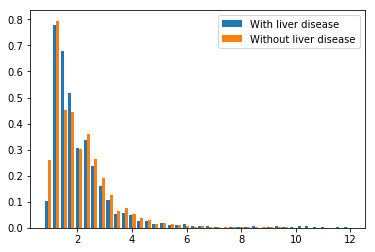

In [15]:
plt.hist([inr_liver_disease, inr_no_liver_disease], bins=40, density=True, label=['With liver disease', 'Without liver disease'])
plt.legend()

In [16]:
inr_sickle = []
inr_no_sickle = []
for i in np.where(sickle == 0)[0]:
    inr_no_sickle.append(data[i]['obs_y'])
for i in np.where(sickle == 1)[0]:
    inr_sickle.append(data[i]['obs_y'])
inr_sickle = np.concatenate(inr_sickle)
inr_no_sickle = np.concatenate(inr_no_sickle)

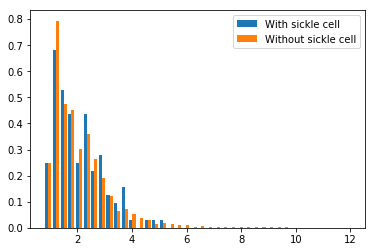

In [17]:
plt.hist([inr_sickle, inr_no_sickle], bins=40, density=True, label=['With sickle cell', 'Without sickle cell'])
plt.legend()

### Treatments

In [18]:
def num_treatment(treatment_name):
    num_t = []
    for d in data:
        num_t.append(len(d[treatment_name + '_times']))

    num_t = np.array(num_t)
    print('Number of times ' + treatment_name +  ' is given')
    unique = np.unique(num_t, return_counts=True)
    print('Unique values : {}'.format(unique[0]))
    print('Counts for unique values : {}'.format(unique[1]))

In [19]:
num_treatment('nsaid')
num_treatment('anticoagulant')
num_treatment('aspirin')

Number of times nsaid is given
Unique values : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  37  41
  47  48  68  72  74 109 131]
Counts for unique values : [1310  323  190  146  108   75   49   68   46   31   16   15   24   18
   12   13   14    9    6    6    4    3    6    5    2    1    2    2
    4    1    3    1    1    1    1    1    1    1    1    1    1    1
    1]
Number of times anticoagulant is given
Unique values : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  48  49  50  51  52  53  54
  56  57  59  61  63  65  68  70  72  73  74  75  78  79  81  83  85  89
 103 105 110 116 122 143 163 166 224 227]
Counts for unique values : [170  63 115 175 199 177 149 126  79  88  98  60  89  71  73  74  80  67
  53  57  41  37  49  29  20  26  11  26 

In [20]:
print('avg interval between nsaid: {}'.format(np.mean(avg_interval(data, 'nsaid'))))
print('avg interval between anticoagulant: {}'.format(np.mean(avg_interval(data, 'anticoagulant'))))
print('avg interval between aspirin: {}'.format(np.mean(avg_interval(data, 'aspirin'))))

avg interval between nsaid: 2136.203516816744
avg interval between anticoagulant: 1136.4531503337819
avg interval between aspirin: 1613.144137578135


In [21]:
print('95% has avg interval between nsaid larger than: {}'.format(np.percentile(avg_interval(data, 'nsaid'), 5)))
print('95% has avg interval between anticoagulant larger than: {}'.format(np.percentile(avg_interval(data, 'anticoagulant'), 5)))
print('95% has avg interval between aspirin larger than: {}'.format(np.percentile(avg_interval(data, 'aspirin'), 5)))

95% has avg interval between nsaid larger than: 408.0
95% has avg interval between anticoagulant larger than: 446.525
95% has avg interval between aspirin larger than: 1237.1136363636363


In [22]:
treatments = ['nsaid', 'anticoagulant', 'aspirin']

def num_treatments_before_first_obs(name):
    num_t = []
    for d in data:
        first_obs = d['obs_times'][0]
        num_t.append(np.where(np.array(d[name+'_times']) < first_obs)[0].shape[0])
    num_t = np.array(num_t)
    return np.unique(num_t, return_counts=True)

In [23]:
num_treatments_before_first_obs('anticoagulant')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 21, 22, 23, 24, 46]),
 array([2196,  121,  114,   29,   14,    7,    5,    6,    6,    3,    2,
           1,    3,    2,    2,    1,    3,    1,    2,    1,    1,    2,
           1,    1]))

In [24]:
a = np.array([1, 2, 3, 4])
np.where(a < 3)[0].shape[0]

2

### Sepsis

In [25]:
sepsis = []
for d in data:
    sepsis.append(d['sepsis'])
sepsis = np.array(sepsis)
sepsis_unique = np.unique(sepsis, return_counts=True)
print('Sepsis: {}'.format(sepsis_unique[1][0]))
print('No Sepsis: {}'.format(sepsis_unique[1][1]))

Sepsis: 1720
No Sepsis: 804


In [26]:
def plot(n):
    times = data[n]['obs_times']
    inr = data[n]['obs_y']
    fig = plt.figure()
    plt.plot(times, inr, '.', label = 'observed inr')
    names = ['nsaid', 'anticoagulant', 'aspirin']
    colors = ['r', 'g', 'c']
    for i, name in enumerate(names):
        treatment = data[n][name + '_times']
        for t in treatment:
            plt.axvline(x=t, linestyle=':', color=colors[i])
    tf = np.concatenate(data[n]['transfusion_times'])
    for t in tf:
        plt.axvline(x=t, linestyle=':', color='y')
    plt.legend()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()

## Analysis after Preprocessing

In [41]:
bin_size = 60 * 18
cutoff = 5

In [28]:
data = np.load('../Data/inr_preprocessed_data.npz')
y, X, c, X_prev = data['y_mtx'], data['X_mtx'], data['c_mtx'], data['X_prev_mtx']

In [29]:
y.shape

(1821, 123)

In [30]:
print('percentage of patients in the data with liver disease: {}'.format\
      (np.nonzero(c[:, 0])[0].shape[0] / c.shape[0] * 100))
print('percentage of patients in the data with sickle cell: {}'.format\
      (np.nonzero(c[:, 1])[0].shape[0] / c.shape[0] * 100))

percentage of patients in the data with liver disease: 5.766062602965404
percentage of patients in the data with sickle cell: 0.5491488193300385


Here for each INR observation (say at time t, t is a time point after binning), look at whether there is any treatment given at time t-1 or t-2. If so, calculate the difference between the INR value at time t and the previous observed INR value. If the difference is negative, then we say a treatment has nonincreasing effect. We do this for each of the 4 treatments

In [42]:
treatment_types = ['nsaid', 'transfusion_plasma', 'transfusion_platelet', 'anticoagulant', 'aspirin']
num_past_time = 3 # number of time points in the past to check for effect 
for j in range(5):
    total_treatment_effect = []
    
    for time in range(1, num_past_time+1):
        single_effect = []
            
        for n in range(y.shape[0]):
            treatment = np.nonzero(X[n, :, j])[0]
            if treatment.shape[0] > 0:        
                inr_index = np.where(np.invert(np.isnan(y[n, :])))[0]
                prev_inr = np.nan
                # for each inr measurements, if a treatment is given at one of its previous time points (within num_past_time)
                # store the difference between current inr measurements and the preivous inr measurements
                for i in inr_index:
                    prev_day = i-time
                    curr_inr = y[n, i]
                    if prev_day in treatment:
                        total_treatment_effect.append(curr_inr - prev_inr)
                        single_effect.append(curr_inr - prev_inr)    
                    prev_inr = curr_inr
        pct = np.nan
        if single_effect:
            single_effect = np.array(single_effect)
            pct_single_effect = np.where(single_effect > 0)[0].shape[0] / single_effect.shape[0] * 100
            print('Percentage of {} given {} days before with increasing effect on INR: {}'. \
                format(treatment_types[j], time*bin_size/60/24, pct_single_effect))
                    
    total_treatment_effect = np.array(total_treatment_effect)
    pct_total_effect = np.where(total_treatment_effect > 0)[0].shape[0] / total_treatment_effect.shape[0] * 100
    print('Percentage of the {} with increasing effect on INR: {}'.format(treatment_types[j], pct_total_effect))

Percentage of nsaid given 0.75 days before with increasing effect on INR: 50.047846889952154
Percentage of nsaid given 1.5 days before with increasing effect on INR: 50.28750653423941
Percentage of nsaid given 2.25 days before with increasing effect on INR: 50.028587764436814
Percentage of the nsaid with increasing effect on INR: 50.121696801112655
Percentage of transfusion_plasma given 0.75 days before with increasing effect on INR: 56.369924141008475
Percentage of transfusion_plasma given 1.5 days before with increasing effect on INR: 59.21862756072988
Percentage of transfusion_plasma given 2.25 days before with increasing effect on INR: 57.78318774165832
Percentage of the transfusion_plasma with increasing effect on INR: 57.78938906752411
Percentage of transfusion_platelet given 0.75 days before with increasing effect on INR: 15.196078431372548
Percentage of transfusion_platelet given 1.5 days before with increasing effect on INR: 35.714285714285715
Percentage of transfusion_platele

In [32]:
def find_common_elements(a, b):
    count = 0
    if a.shape[0] == 0 or b.shape[0] == 0:
        return count
    for ele in a:
        if ele in b:
            count += 1
    return count

In [33]:
atc_total = 0
with_ns = 0
with_plasma_tf = 0
with_platelet_tf = 0
with_asp = 0
for n in range(y.shape[0]):
    atc = np.nonzero(X[n, :, 3])[0]
    atc_total += atc.shape[0]
    if atc.shape[0] > 0:
        ns = np.nonzero(X[n, :, 0])[0]
        plasma_tf = np.nonzero(X[n, :, 1])[0]
        platelet_tf = np.nonzero(X[n, :, 2])[0]
        asp = np.nonzero(X[n, :, 4])[0]
        with_ns += find_common_elements(atc, ns)
        with_plasma_tf += find_common_elements(atc, plasma_tf)
        with_platelet_tf += find_common_elements(atc, platelet_tf)
        with_asp += find_common_elements(atc, asp)
print('anticoagulant is administered {}% times with nsaid'.format(with_ns / atc_total * 100))
print('anticoagulant is administered {}% times with plasma transfusion'.format(with_plasma_tf / atc_total * 100))
print('anticoagulant is administered {}% times with platelet transfusion'.format(with_platelet_tf / atc_total * 100))
print('anticoagulant is administered {}% times with aspirin'.format(with_asp / atc_total * 100))

anticoagulant is administered 0.0% times with nsaid
anticoagulant is administered 0.0% times with plasma transfusion
anticoagulant is administered 59.09090909090909% times with platelet transfusion
anticoagulant is administered 4.545454545454546% times with aspirin


### Effects of Variables on INR
* In healthy people an INR of 1.1 or below is considered normal. An INR range of 2.0 to 3.0 is generally an effective therapeutic range for people taking warfarin for disorders such as atrial fibrillation or a blood clot in the leg or lung. In certain situations, such as having a mechanical heart valve, you might need a slightly higher INR.
* If INR is too high, the blood is clotting too slow. https://www.mayoclinic.org/tests-procedures/prothrombin-time/about/pac-20384661
* Effects of treatments
    * Nsaid: Increase (when administered with warfarin) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2826747/
    * Transfusion
        * Plasma: Unclear https://www.ncbi.nlm.nih.gov/pubmed/16934060
        * Platelets: (Should) Decrease (since it helps form blood clots)
    * Anticoagulant: Increase
        * Delay effect: "Because warfarin has a long half-life, increases in the INR may not be noted for 24 to 36 hours after administration of the first dose, and maximum anticoagulant effect may not be achieved for 72 to 96 hours." https://www.aafp.org/afp/1999/0201/p635.html
    * Aspirin: Increase https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1492499/ https://bpac.org.nz/BT/2010/November/inr.aspx
* Chronics
    * Liver disease: Unclear
        * "Both procoagulants and anticoagulants that occur naturally in the body are produced by the liver, affecting your INR" http://www.ptinr.com/en/home/warfarin-you/general-information/health-conditions/liver-liver-disease-and-warfarin.html
    * Sickle cell: Decrease
        * "Sickle cell disorders, such as Hb SS and Hb SC, are associated with a hypercoagulable state that may contribute to the vaso-occlusive episodes observed in the disorders." https://www.ncbi.nlm.nih.gov/pubmed/11835343
* Demographics
    * Age: Decrease
        * In patients aged 65 years or older, the mean INR at the time of a major bleeding event was significantly lower than that in patients younger than 65 years (INR 3.1 vs 4.2, respectively; p=0.01). For every 1-year increase in age, mean INR at the time of a major bleeding event decreased by 0.03 (p=0.02). https://www.ncbi.nlm.nih.gov/pubmed/15162894
* Interaction
    * Warfarin is likely to have interaction with other types of treatments
        * "Dose has an inverse relation with age"
        * "Drug interactions need to be considered when warfarin therapy is initiated." https://www.aafp.org/afp/1999/0201/p635.html